# 动手学深度学习 8.1 序列模型 示例代码

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset

生成人工数据集

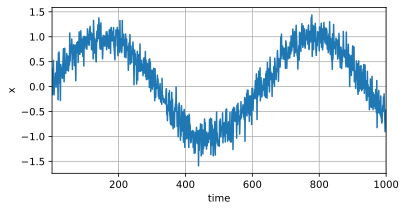

In [2]:
T = 1000  # 生成1000个点
tau = 4

time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

# 生成特征x(t-1), ..., x(t-tau), 一共有T-tau个
features = torch.zeros((T - tau, tau))
for i in range(tau):
	features[:, i] = x[i:T - tau + i]

# 生成标签x(t)
labels = x[tau:].reshape((-1, 1))

# 生成dataloader
train_dataset = TensorDataset(features[:600], labels[:600]) # type: ignore
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

创建网络, loss, optimizer

In [3]:
class MLP(nn.Module):
	def __init__(self, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)

		self.model = nn.Sequential(
			nn.Linear(4, 10),
			nn.ReLU(),
			nn.Linear(10, 1)
		)
	
	def forward(self, x):
		return self.model(x)

model = MLP()
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

开始训练

In [5]:
for epoch in range(5):
	for X, y in train_loader:
		optimizer.zero_grad()
		l = loss(model(X), y)
		l.sum().backward()
		optimizer.step()
	print(f'epoch {epoch + 1}, loss {l.item()}')	# type: ignore

epoch 1, loss 0.05610983446240425
epoch 2, loss 0.043637536466121674
epoch 3, loss 0.050929632037878036
epoch 4, loss 0.07022475451231003
epoch 5, loss 0.05779697373509407


单步预测

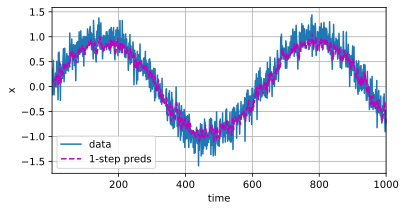

In [13]:
one_step_predictions = model(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), one_step_predictions.detach().numpy()], 'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

使用模型的输出作为输入预测

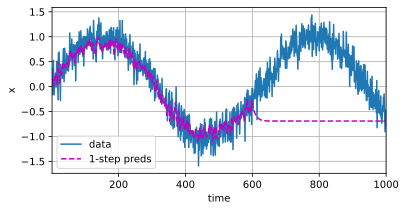

In [18]:
multistep_predictions = torch.zeros(T)
multistep_predictions[:600] = x[:600]
for i in range(0, 600):
	multistep_predictions[i] = model(features[i].reshape((1, -1)))
for i in range(600, T):
	multistep_predictions[i] = model(multistep_predictions[i - tau:i].reshape((1, -1)))
d2l.plot([time, time], [x.detach().numpy(), multistep_predictions.detach().numpy()], 'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))